#Load dataframe

###Load packages and dataframe

In [0]:
## Loading packages 
%%capture
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.exceptions import ConvergenceWarning
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import pandas as pd
import io
import requests
import warnings


###Downloads dataframes

Dataframes are automatically reformatted when downloaded so that the inputted dataframes are consistent, no matter what order cells are run in.

In [0]:
#Downloads stacking data (c) and converts strings to binary
%%capture
url="https://drive.google.com/uc?id=1e-SHtWDtg4mD_th3_4Jmq9r1iiQC32wT"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')), sep = " ")
print("[INFO]: loaded data")

c.stacking[c.stacking == 'stack'] = 1 
c.stacking[c.stacking == 'non-stack'] = 0
c.orientation[c.orientation == 'anti'] = 1
c.orientation[c.orientation == 'syn'] = 0
c.sugar_puckering[c.sugar_puckering == "~C3'-endo"] = 1
c.sugar_puckering[c.sugar_puckering == "~C2'-endo"] = 0
c.pseudoknot[c.pseudoknot == 'non-pseudoknotted'] = 1 
c.pseudoknot[c.pseudoknot == 'pseudoknotted'] = 0
c.head()
gua = np.zeros(3068)
gua[c.resname == 'GUA'] = 1 
c["GUA"] = gua
ade = np.zeros(3068)
ade[c.resname == 'ADE'] = 1 
c["ADE"] = ade
cyt = np.zeros(3068)
cyt[c.resname == 'CYT'] = 1 
c["CYT"] = cyt
ura = np.zeros(3068)
ura[c.resname == 'URA'] = 1 
c["URA"] = ura
c['GUA'] = c['GUA'].astype(int)
c['ADE'] = c['ADE'].astype(int)
c['CYT'] = c['CYT'].astype(int)
c['URA'] = c['URA'].astype(int)

In [0]:
#Downloads and corrects SASA (d) data
##SASA data contains 6 extra residues not in stacking data that must be removed
url="https://drive.google.com/uc?id=1Y3Imx-lTjGKCQAFqEKTbaMSzFARtwEFN"
s=requests.get(url).content
d=pd.read_csv(io.StringIO(s.decode('utf-8')), sep = " ", error_bad_lines=False)

for i in range(0, len(c)):
  if d.iat[i, 2] != c.iloc[i, 1]:
    d = d.drop([i])
    d = d.reset_index(drop=True)
  else:
    pass

###Create c_all (definitions used)



In [0]:
#Definitions for setting up nearest neighbors 
NUMBER_CHEMICAL_SHIFT_TYPE = 23

def get_cs_all(cs_all, id = "2KOC"):
  return(cs_all[(cs_all.id == id)])

def get_cs_residues(cs_i, resid, dummy = 0):
  
  cs_tmp = cs_i[(cs_i.resid == resid)].drop(['Unnamed: 0', 'resid', 'id', 'resname', 'base_pairing', 'orientation', 'sugar_puckering','stacking', 'pseudoknot'], axis=1)
  info_tmp = cs_i[(cs_i.resid == resid)]
  if (cs_tmp.shape[0] != 1):
     return(dummy*np.ones(shape=(1, NUMBER_CHEMICAL_SHIFT_TYPE)))
  else:
     return(cs_tmp.values)
    
def get_resnames(cs_i, resid, dummy = "UNK"):
  
  cs_tmp = cs_i[(cs_i.resid == resid)]  
  if (cs_tmp.shape[0] != 1):
     return(dummy)
  else:
     return(cs_tmp['resname'].values[0])

def get_cs_features(cs_i, resid, neighbors=1):
  
  cs = []
  resnames = []
  for i in range(resid-neighbors, resid+neighbors+1):
    cs.append(get_cs_residues(cs_i, i))
    resnames.append(get_resnames(cs_i, i))
  return(resnames, np.array(cs))

def get_columns_names(neighbors = 3, chemical_shift_types = 23):
  # 'resname',
  #'Unnamed: 0', 
  columns = ['Unnamed: 0', 'resid', 'id', 'resname', 'base_pairing', 'orientation', 'sugar_puckering','stacking', 'pseudoknot']
  for i in range(0, neighbors*chemical_shift_types):
    columns.append(i)
  return(columns)

def write_out_resname(neighbors=1):
  
  colnames = []
  for i in range(1-neighbors-1, neighbors+1):
    if i < 0: 
      colnames.append('R%s'%i)
    elif i > 0: 
      colnames.append('R+%s'%i)
    else: 
      colnames.append('R')
  return(colnames)



def get_cs_features_rna(cs, neighbors=1, retain = ['id','stacking', 'resid']):

  all_features = []
  all_resnames = []
  for resid in cs['resid'].unique():
    resnames, features = get_cs_features(cs, resid, neighbors)
    all_features.append(features.flatten())
    all_resnames.append(resnames)

  all_resnames = pd.DataFrame(all_resnames, dtype='object', columns = write_out_resname(neighbors))
  all_features = pd.DataFrame(all_features, dtype='object')
  info = pd.DataFrame(cs[retain].values, dtype='object', columns = retain)
  return(pd.concat([info, all_features], axis=1))

def get_cs_features_rna_all(cs, neighbors = 2):
  ids = cs['id'].unique()
  for i,id in enumerate(ids):
    if i == 0:
      cs_new = get_cs_features_rna(get_cs_all(cs, id), neighbors)
    else:
      cs_new = cs_new.append(get_cs_features_rna(get_cs_all(cs, id), neighbors), sort = False)     
  
  return(cs_new)

###Create training and testing sets

In [0]:
def create_training_testing(cs, leave_out = "2KOC", target_name = 'stacking', neighbors = 2, drop_names = ['id','stacking','resid']):

  drop_names = drop_names #+ list(write_out_resname(neighbors))  
  
  
  train = cs[(cs.id != leave_out)]
  trainX = train.drop(drop_names, axis=1)
  trainy = train[target_name]
 
 
  test = cs[(cs.id == leave_out)]
  testX = test.drop(drop_names, axis=1)
  testy = test[target_name]
  
  
  return(trainX.values, trainy.values, testX.values, testy.values)

In [8]:

NEIGHBORS = 0
cs_all = get_cs_features_rna_all(c, neighbors = NEIGHBORS)
scalers = []
f1score = []

## write for loop 

ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = create_training_testing(cs_all, leave_out = id, neighbors = NEIGHBORS)
  scalers.append(StandardScaler())
  scalers[i].fit(trainX)
  trainX_scaled = scalers[i].transform(trainX)
  testX_scaled = scalers[i].transform(testX)
  clf = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=10, activation='relu', alpha=1e-4, solver='sgd', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, np.int_(trainy))
  y_true, y_pred = np.int_(testy) , clf.predict(testX_scaled)
  f1score.append(f1_score(y_true,y_pred))
  
np.mean(f1score)


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/loc

0.9238456268960118

In [9]:
NEIGHBORS = 1
cs_all = get_cs_features_rna_all(c, neighbors = NEIGHBORS)
scalers = []
f1score = []

## write for loop 

ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = create_training_testing(cs_all, leave_out = id, neighbors = NEIGHBORS)
  scalers.append(StandardScaler())
  scalers[i].fit(trainX)
  trainX_scaled = scalers[i].transform(trainX)
  testX_scaled = scalers[i].transform(testX)
  clf = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=10, activation='relu', alpha=1e-4, solver='sgd', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, np.int_(trainy))
  y_true, y_pred = np.int_(testy) , clf.predict(testX_scaled)
  f1score.append(f1_score(y_true,y_pred))
  
np.mean(f1score)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/loc

0.9196972245333478

In [0]:
NEIGHBORS = 2
cs_all = get_cs_features_rna_all(c, neighbors = NEIGHBORS)
scalers = []
f1score = []

## write for loop 

ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = create_training_testing(cs_all, leave_out = id, neighbors = NEIGHBORS)
  scalers.append(StandardScaler())
  scalers[i].fit(trainX)
  trainX_scaled = scalers[i].transform(trainX)
  testX_scaled = scalers[i].transform(testX)
  clf = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=10, activation='relu', alpha=1e-4, solver='sgd', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, np.int_(trainy))
  y_true, y_pred = np.int_(testy) , clf.predict(testX_scaled)
  f1score.append(f1_score(y_true,y_pred))
  
np.mean(f1score)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/loc

0.9148807262197263

In [0]:
NEIGHBORS = 3
cs_all = get_cs_features_rna_all(c, neighbors = NEIGHBORS)
scalers = []
f1score = []

## write for loop 

ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = create_training_testing(cs_all, leave_out = id, neighbors = NEIGHBORS)
  scalers.append(StandardScaler())
  scalers[i].fit(trainX)
  trainX_scaled = scalers[i].transform(trainX)
  testX_scaled = scalers[i].transform(testX)
  clf = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=10, activation='relu', alpha=1e-4, solver='sgd', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, np.int_(trainy))
  y_true, y_pred = np.int_(testy) , clf.predict(testX_scaled)
  f1score.append(f1_score(y_true,y_pred))
  
np.mean(f1score)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/loc

0.9150027973957722

In [0]:
NEIGHBORS = 4
cs_all = get_cs_features_rna_all(c, neighbors = NEIGHBORS)
scalers = []
f1score = []

## write for loop 

ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = create_training_testing(cs_all, leave_out = id, neighbors = NEIGHBORS)
  scalers.append(StandardScaler())
  scalers[i].fit(trainX)
  trainX_scaled = scalers[i].transform(trainX)
  testX_scaled = scalers[i].transform(testX)
  clf = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=10, activation='relu', alpha=1e-4, solver='sgd', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, np.int_(trainy))
  y_true, y_pred = np.int_(testy) , clf.predict(testX_scaled)
  f1score.append(f1_score(y_true,y_pred))
  
np.mean(f1score)
# Look at distribution of f1 score, precision, and recall 

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/loc

0.9187791710432841

In [0]:
NEIGHBORS = 5
cs_all = get_cs_features_rna_all(c, neighbors = NEIGHBORS)
scalers = []
f1score = []

## write for loop 

ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = create_training_testing(cs_all, leave_out = id, neighbors = NEIGHBORS)
  scalers.append(StandardScaler())
  scalers[i].fit(trainX)
  trainX_scaled = scalers[i].transform(trainX)
  testX_scaled = scalers[i].transform(testX)
  clf = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=10, activation='relu', alpha=1e-4, solver='sgd', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, np.int_(trainy))
  y_true, y_pred = np.int_(testy) , clf.predict(testX_scaled)
  f1score.append(f1_score(y_true,y_pred))
  
np.mean(f1score)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/loc

0.9169989472824476

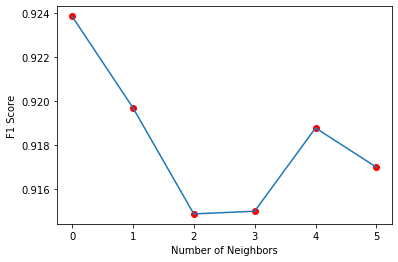

In [0]:
import matplotlib.pyplot as plt
plt.plot([0, 1, 2, 3, 4, 5], [0.9238456268960118, 0.9196972245333478, 0.9148807262197263, 0.9150027973957722, 0.9187791710432841, 0.9169989472824476], 'ro')
plt.plot([0, 1, 2, 3, 4, 5], [0.9238456268960118, 0.9196972245333478, 0.9148807262197263, 0.9150027973957722, 0.9187791710432841, 0.9169989472824476])
plt.xlabel('Number of Neighbors')
plt.ylabel('F1 Score')
plt.show()

# SASA


In [0]:
def SASAcreate_training_testing(cs, leave_out = "2KOC", target_sasa = 'sasa_All_atoms', neighbors = 2, drop_names = ['id','stacking','resid']):

  drop_names = drop_names #+ list(write_out_resname(neighbors))  
  
  
  train = cs[(cs.id != leave_out)]
  trainX = train.drop(drop_names, axis=1)
  trainSASA = cs[cs.id != leave_out]
  trainy = trainSASA[target_sasa]
 
 
  test = cs[(cs.id == leave_out)]
  testX = test.drop(drop_names, axis=1)
  testSASA = cs[cs.id == leave_out]
  testy = testSASA[target_sasa]
  
  
  return(trainX.values, trainy.values, testX.values, testy.values)

###sasa-All-atoms

Best: activation = logisitc, solver = sgd

In [11]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 0
target = 'sasa-All-atoms'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='logistic', alpha=1e-4, solver='sgd', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/loc

0.7766752899088718

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 1
target = 'sasa-All-atoms'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='logistic', alpha=1e-4, solver='sgd', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/loc

0.7766752899088718

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 2
target = 'sasa-All-atoms'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='logistic', alpha=1e-4, solver='sgd', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/loc

0.7766752899088718

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 3
target = 'sasa-All-atoms'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='logistic', alpha=1e-4, solver='sgd', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/loc

0.7766752899088718

###sasa-Total-Side

Best: activation = logistic, solver = lbfgs

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 0
target = 'sasa-Total-Side'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='logistic', alpha=1e-4, solver='lbfgs', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

0.2534522569461287

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 1
target = 'sasa-Total-Side'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='logistic', alpha=1e-4, solver='lbfgs', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

0.2534522569461287

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 2
target = 'sasa-Total-Side'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='logistic', alpha=1e-4, solver='lbfgs', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

0.2534522569461287

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 3
target = 'sasa-Total-Side'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='logistic', alpha=1e-4, solver='lbfgs', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

0.2534522569461287

###sasa-Main-Chain

Best: activation = tanh, solver = lbfgs

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 0
target = 'sasa-Main-Chain'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='tanh', alpha=1e-4, solver='lbfgs', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

0.14277998950016096

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 1
target = 'sasa-Main-Chain'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='tanh', alpha=1e-4, solver='lbfgs', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

0.14277998950016096

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 2
target = 'sasa-Main-Chain'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='tanh', alpha=1e-4, solver='lbfgs', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

0.14277998950016096

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 3
target = 'sasa-Main-Chain'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='tanh', alpha=1e-4, solver='lbfgs', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

0.14277998950016096

###sasa-Non-polar

Best: activation = logistic, solver = adam

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 0
target = 'sasa-Non-polar'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='logistic', alpha=1e-4, solver='adam', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/loc

0.8200055745377633

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 1
target = 'sasa-Non-polar'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='logistic', alpha=1e-4, solver='adam', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/loc

0.8200055745377633

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 2
target = 'sasa-Non-polar'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='logistic', alpha=1e-4, solver='adam', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/loc

0.8200055745377633

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 3
target = 'sasa-Non-polar'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='logistic', alpha=1e-4, solver='adam', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/loc

0.8200055745377633

###sasa-All-polar

Best: activation = tanh, solver = adam

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 0
target = 'sasa-All-polar'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='tanh', alpha=1e-4, solver='adam', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/loc

0.3367408123786228

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 1
target = 'sasa-All-polar'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='tanh', alpha=1e-4, solver='adam', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/loc

0.3367408123786228

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 2
target = 'sasa-All-polar'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='tanh', alpha=1e-4, solver='adam', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/loc

0.3367408123786228

In [0]:
from sklearn.neural_network import MLPRegressor
NEIGHBORS = 3
target = 'sasa-All-polar'
cs_all = get_cs_features_rna_all(c, neighbors = 0)
cs_all = cs_all.reset_index(drop=True)
cs_all[target] = d[target]
scalersx = []
scalersy = []
f1score = []


ids = c['id'].unique()
for i,id in enumerate(ids):
  trainX, trainy, testX, testy = SASAcreate_training_testing(cs_all, target_sasa = target, neighbors = NEIGHBORS)
  scalersx.append(StandardScaler())
  scalersx[i].fit(trainX)
  trainX_scaled = scalersx[i].transform(trainX)
  testX_scaled = scalersx[i].transform(testX)
  #scalersy.append(StandardScaler())
  #scalersy[i].fit(trainy)
  #trainy_scaled = strain
  #testy_scaled = scalersx[i].transform(testy)
  clf = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=10, activation='tanh', alpha=1e-4, solver='adam', verbose=0, tol=1e-4, random_state=1, learning_rate_init=.1)
  clf.fit(trainX_scaled, trainy)
  y_true, y_pred = testy , clf.predict(testX_scaled)
  f1score.append(clf.score(testX_scaled, testy))

np.mean(f1score)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/loc

0.3367408123786228

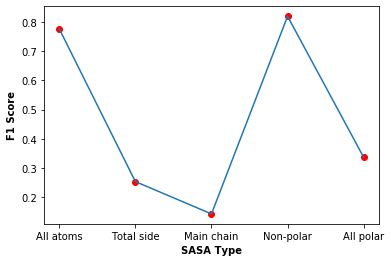

In [0]:
import matplotlib.pyplot as plt
plt.plot(["All atoms", "Total side", "Main chain", "Non-polar", "All polar"], [0.7766752899088718, 0.2534522569461287, 0.14277998950016096, 0.8200055745377633, 0.3367408123786228], 'ro')

plt.plot(["All atoms", "Total side", "Main chain", "Non-polar", "All polar"], [0.7766752899088718, 0.2534522569461287, 0.14277998950016096, 0.8200055745377633, 0.3367408123786228])

plt.xlabel('SASA Type', weight="bold")
plt.ylabel('F1 Score', weight="bold")
plt.show()